In [144]:
from typing import Any
import matplotlib.pyplot as plt
import numpy as np
import leapint

In [145]:
from typing import Any

import numpy as np

#The following functions assume the plane of orbit is the x, y axis, with positive 

def initmice(R_min:float, mass:float, time_unit:float, wA:float, wB:float, iA:float, iB:float, e:float, epsilon:float) -> tuple :

    #Disk Inits in galaxy frame
    posA, velA = initdisk(R_min, mass, epsilon)
    posB, velB = initdisk(R_min, mass, epsilon)

    #Rotate galaxies according to angles
    posA_rot, velA_rot = rotdisk(posA, velA, iA, -1)
    posB_rot, velB_rot = rotdisk(posB, velB, iB, 1)

    #Translate each galacy so COM is at origin
    Rapoc = R_min*(1+e)/(1-e)
    print(Rapoc)
    pos_m = np.array([[0, -Rapoc, 0], [0, Rapoc, 0]])

    posA_CM = posA_rot+pos_m[0]
    posB_CM = posB_rot+pos_m[1]

    #Set the velocities of the each galaxy

    #Semimajor axis
    a = (R_min+Rapoc)/2

    #Use vis a vis equation for orbital valocity
    vel_mag = np.sqrt(2*mass*(2/(Rapoc)-1/a)) 

    #Set Galaxy velocities
    vel_m = np.array([[vel_mag, 0, 0], [-vel_mag, 0, 0]])

    #Propogate velocities to masslessparticles
    velA_CM = velA_rot+vel_m[0]
    velB_CM = velB_rot+vel_m[1]

    pos_CM = np.concatenate((posA_CM, posB_CM), axis=0)
    vel_CM = np.concatenate((velA_CM, velB_CM), axis=0)

    return pos_m, vel_m, pos_CM, vel_CM

    
def initdisk(R_min:float, mass:float, epsilon:float) ->tuple:
    pos = np.zeros((297, 3))
    vel = np.zeros((297, 3))
    curr = 0
    for i in range(0, 11):
        num_particles = 3*i + 12
        radius = (0.05*i + 0.2)*R_min
        for j in range(0, num_particles):
            angle = (2.0*np.pi /num_particles)*j
            pos[curr] = (radius*np.cos(angle), radius*np.sin(angle), 0)
            velmag = np.sqrt(mass*radius/(radius**2+epsilon**2))
            veldirnorm = np.array([-1*pos[curr, 1], pos[curr, 0], 0]) / np.sqrt(pos[curr, 1]**2+pos[curr, 0]**2)
            vel[curr] = velmag*veldirnorm
            curr+=1
    return pos, vel

def rotdisk(pos: np.ndarray[float, Any], vel: np.ndarray[float, Any], i:float, n:float) -> tuple:

    #Adjust angle based on whethere rotation is around postive or negative x axis
    iadj = n*i*-1
    #Rotate positions and velocity by -i around positive
    #Create Rot Matrix around x axis
    rot = np.array([[1, 0, 0], [0, np.cos(iadj), -1*np.sin(iadj)], [0, np.sin(iadj), np.cos(iadj)]])

    pos_rot = (rot@pos.transpose()).transpose()
    vel_rot = (rot@vel.transpose()).transpose()
    return pos_rot, vel_rot



In [132]:
pos_m, vel_m, pos_CM, vel_CM = initmice(25, 10**11, 1, 1, 1, np.pi/12, np.pi/3, 0.6, 0.01)

100.0


(594, 3)

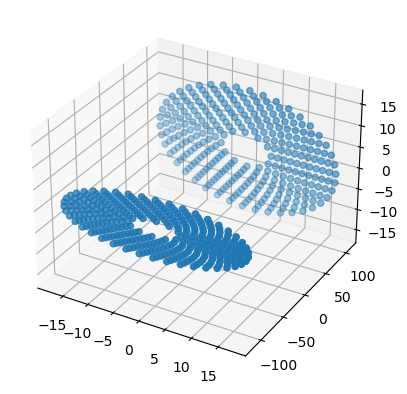

In [133]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_zlim([-0.7*25, 0.7*25])
ax.scatter(pos_CM.transpose()[0], pos_CM.transpose()[1], pos_CM.transpose()[2])
np.shape(pos_CM)


In [134]:
from typing import Any

import numpy as np
import gravity
def leapfrog(init_pos: np.ndarray[float, Any], init_vel: np.ndarray[float, Any], init_pos_massive: np.ndarray[float, Any], init_vel_massive: np.ndarray[float, Any], timestep: int, dt: float, masses: np.ndarray[float, Any], epsilon: float) -> tuple:
    """leapfrog integration for 3 massless bodies

    Parameters
    ----------
    init_pos : np.ndarray[float, (n,3)]
        Array of initial position of 3 massless bodies
    init_vel : np.ndarray[float, (n,3)]
        Array of initial velocity of 3 massless bodies
    init_pos_massive : np.ndarray[float, (m,3)]
        Array of initial position of 2 massive points
    init_vel_massive : np.ndarray[float, (m,3)]
        Array of initial velocity of 2 massive points
    timestep : int
        number of time we integrate
    dt : float
        smaller time_step to do integration
    masses : np.ndarray[float, (m,)]
        Masses corresponding to the given points.
    epsilon : float
        Softening factor

    Returns
    -------
    tuple
        _description_
    """
    
    # set the number of massless particle as n and massive particle as m
    m,a = init_pos_massive.shape
    n,a = init_pos.shape
    
    # set the matrix that we will use in the leapfrog integrator
    pos = np.zeros((n, 3))
    vel = np.zeros((n, 3))
    pos_m = np.zeros((m, 3))
    vel_m = np.zeros((m, 3))

    # set the output array of 3 massless bodies
    position = np.zeros((timestep + 1, n, 3))
    velocity = np.zeros((timestep + 1, n, 3))

    # set the first tensor of the output to be our initial condition
    position[0, :, :] = init_pos
    velocity[0, :, :] = init_vel

    # set the output array of 2 massive bodies
    position_m = np.zeros((timestep + 1, m, 3))
    velocity_m = np.zeros((timestep + 1, m, 3))

    # set the first tensor of the output to be our initial condition
    position_m[0, :, :] = init_pos_massive
    velocity_m[0, :, :] = init_vel_massive

    for i in range(timestep):

        # find the half step velocity
        vel = velocity[i, :, :] + (gravity.grav_3body(position[i, :, :],
                                   position_m[i, :, :], masses, epsilon)*dt/2)
        vel_m = velocity_m[i, :, :] + \
            (gravity.grav_direct(
                position_m[i, :, :], masses, epsilon)*dt/2)

        # find the full-step position
        pos = position[i, :, :] + (vel*dt)
        pos_m = position_m[i, :, :] + (vel_m*dt)

        # find the full-step velocity
        vel = vel + (gravity.grav_3body(pos, pos_m,
                     masses, epsilon)*dt/2)
        vel_m = vel_m + (gravity.grav_direct(pos_m,
                         masses, epsilon)*dt/2)

        # add our integrated calculation to the output tensor
        position[i+1, :, :] = pos
        velocity[i+1, :, :] = vel
        position_m[i+1, :, :] = pos_m
        velocity_m[i+1, :, :] = vel_m

    return position, velocity, position_m, velocity_m


In [136]:
import matplotlib.animation as animation

In [152]:
mass = 1000
epsilon = 0.001
R_min = 25
iA = np.pi/12
iB = np.pi/4
e = 0.6
num_steps = 500
dt = 0.1


pos_disk, vel_disk = initdisk(25, mass, epsilon=epsilon)


position, velocity, position_m, velocity_m = leapfrog(pos_disk, vel_disk, np.array([[0, 0, 0]]), np.array([[0, 0, 0]]), num_steps, dt, np.array([mass]), epsilon=epsilon)
np.shape(velocity)
#print(velocity[0, 0, 0])
#np.sqrt(velocity[0, 0, 0]**2, velocity[0, 0, 1]**2)
#np.sqrt(velocity[1000, 0, 0]**2, velocity[1000, 0, 1]**2)

(501, 297, 3)

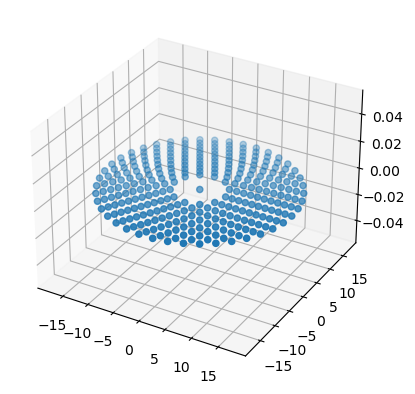

In [148]:
fig = plt.figure()

def animate(i):
    fig.clear()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(np.concatenate((position[i], position_m[i]), axis = 0).transpose()[0], np.concatenate((position[i], position_m[i]), axis = 0).transpose()[1], np.concatenate((position[i], position_m[i]), axis = 0).transpose()[2])
ani = animation.FuncAnimation(fig, animate, frames=np.shape(position)[0])
ani.save('singledisk.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

In [153]:
pos_m, vel_m, pos_cm, vel_cm = initmice(R_min, mass, 0, 0, 0, iA,  iB, e, epsilon)


position, velocity, position_m, velocity_m = leapfrog(pos_cm, vel_cm, pos_m, vel_m, num_steps, dt, np.array([mass, mass]), epsilon=epsilon)
np.shape(velocity)
#print(velocity[0, 0, 0])
#np.sqrt(velocity[0, 0, 0]**2, velocity[0, 0, 1]**2)
#np.sqrt(velocity[1000, 0, 0]**2, velocity[1000, 0, 1]**2)

100.0


(501, 594, 3)

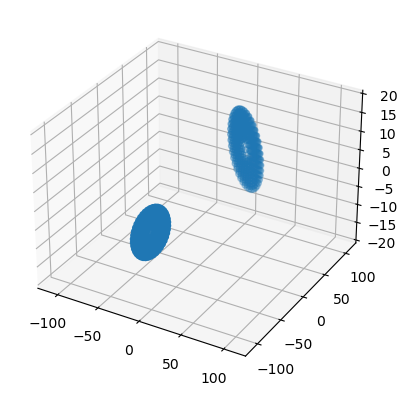

In [155]:
fig = plt.figure()

def animate(i):
    fig.clear()
    ax = fig.add_subplot(projection='3d')
    ax.set_zlim([-20, 20])
    ax.set_xlim([-120, 120])
    ax.set_ylim([-120, 120])
    ax.scatter(np.concatenate((position[i], position_m[i]), axis = 0).transpose()[0], np.concatenate((position[i], position_m[i]), axis = 0).transpose()[1], np.concatenate((position[i], position_m[i]), axis = 0).transpose()[2])
    
ani = animation.FuncAnimation(fig, animate, frames=np.shape(position)[0])
ani.save('fullsim.mp4', fps=30, extra_args=['-vcodec', 'libx264'])